In [1]:
import re
import time
from pathlib import Path
from itertools import chain
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gensim
import gensim.downloader as api
from gensim import corpora
from gensim.models import Word2Vec
from gensim.matutils import softcossim
from gensim.utils import simple_preprocess

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100%; }</style>"))

pd.set_option("max_colwidth", 800)
np.set_printoptions(precision=3, suppress=True)
sns.set_style("darkgrid")
plt.style.use("fivethirtyeight")

In [2]:
dataset = pd.read_csv("Articles_Data/Articles_DS_File.csv")

In [3]:
dataset.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [4]:
dataset["date_created"] = pd.to_datetime(dataset["date_created"])

# OR alternatively:
# dataset["date_created"] = dataset["date_created"].astype("datetime64[ns]")

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time_created  509236 non-null  int64         
 1   date_created  509236 non-null  datetime64[ns]
 2   up_votes      509236 non-null  int64         
 3   down_votes    509236 non-null  int64         
 4   title         509236 non-null  object        
 5   over_18       509236 non-null  bool          
 6   author        509236 non-null  object        
 7   category      509236 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(3), object(3)
memory usage: 27.7+ MB


## 1) Exploratory Data Analysis

### a) Time Created (not used)

In [6]:
dataset.drop("time_created", axis=1, inplace=True)

### b) Date Created

In [7]:
dataset["date_created"].min(), dataset["date_created"].max()

(Timestamp('2008-01-25 00:00:00'), Timestamp('2016-11-22 00:00:00'))

In [8]:
# Count the number of over 18 articles for each year

dataset_date = dataset.groupby(dataset["date_created"].dt.year).agg(Sum_o18=("over_18", "sum"), Count=("over_18", "count"))
dataset_date["Ratio_o18"] = (dataset_date["Sum_o18"] / dataset_date["Count"] * 100).round(2)

In [9]:
dataset_date

,Sum_o18,Count,Ratio_o18
date_created,,,
2008,6.0,22505,0.03
2009,11.0,25115,0.04
2010,6.0,23313,0.03
2011,60.0,38886,0.15
2012,22.0,42643,0.05
2013,81.0,88231,0.09
2014,42.0,92030,0.05
2015,50.0,94621,0.05
2016,42.0,81892,0.05


### c) Upvotes and Downvotes

In [10]:
dataset.describe()

,up_votes,down_votes
count,509236.000000,509236.0
mean,112.236283,0.0
std,541.694675,0.0
min,0.000000,0.0
25%,1.000000,0.0
50%,5.000000,0.0
75%,16.000000,0.0
max,21253.000000,0.0


Quartiles: [    0.     1.     3.     7.    24. 21253.]


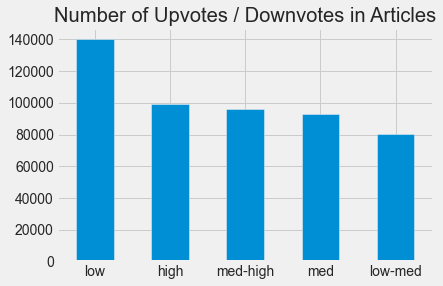

In [11]:
dataset["up_votes_quartile"], quartiles = pd.qcut(dataset["up_votes"], 5, labels=["low", "low-med", "med", "med-high", "high"], retbins=True)
print(f"Quartiles: {quartiles}")

dataset["up_votes_quartile"].value_counts().plot(kind="bar", rot=0)
plt.title("Number of Upvotes / Downvotes in Articles")
plt.show()

# OR alternatively:
# plt.bar(dataset["up_votes_quartile"].value_counts().index, height=dataset["up_votes_quartile"].value_counts().values)

In [12]:
# Mean upvotes 

dataset.groupby("over_18").agg(upvotes_mean=("up_votes", "mean"))

,upvotes_mean
over_18,
False,112.067681
True,380.375000


### d) Over 18

In [13]:
# Imbalanced dataset

pd.value_counts(dataset["over_18"])

False    508916
True        320
Name: over_18, dtype: int64

In [14]:
dataset_o18 = dataset[dataset["over_18"]==True]
dataset_b18 = dataset[dataset["over_18"]==False]

dataset_o18.shape[0], dataset_b18.shape[0]

(320, 508916)

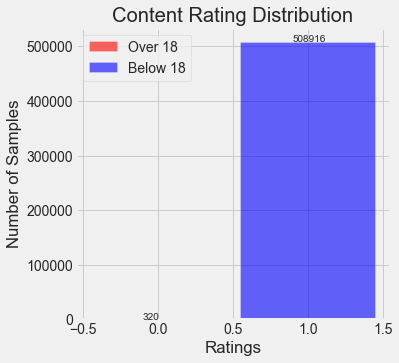

In [15]:
x = [0, 1]
y = [dataset_o18.shape[0], dataset_b18.shape[0]]

plt.figure(figsize=(5, 5))
plt.bar(x[0], y[0], width=0.9, label="Over 18", color="red", alpha=0.6)
plt.bar(x[1], y[1], width=0.9, label="Below 18", color="blue", alpha=0.6)
plt.xlabel("Ratings")
plt.ylabel("Number of Samples")
plt.title("Content Rating Distribution")
plt.legend()

for i in range(len(y)):
    plt.text(x=x[i]-0.1, y=y[i]-0.1, s=y[i], size=10)

In [16]:
dataset["restricted_content"] = dataset["over_18"].map({True: 1, False: 0})

### e) Author

In [17]:
article_cnt_author = pd.value_counts(dataset["author"])
article_cnt_author

davidreiss666    8897
anutensil        5730
DoremusJessup    5037
maxwellhill      4023
igeldard         4013
                 ... 
fistahobo           1
calvinwazoo         1
neolight            1
krystann            1
capri_stylee        1
Name: author, Length: 85838, dtype: int64

In [18]:
dataset["author"].unique().shape

(85838,)

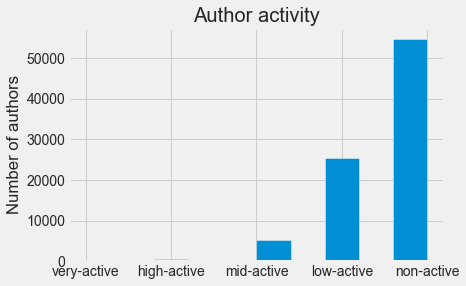

In [19]:
author_articles = pd.cut(article_cnt_author.values, bins=[0, 1, 10, 100, 1000, 10000], labels=["non-active", "low-active", "mid-active", "high-active", "very-active"])
plt.hist(author_articles)
plt.title("Author activity")
plt.ylabel("Number of authors")
plt.show()

In [20]:
# Number of Over 18 articles per author 

dataset.groupby("author").agg(Sum_o18=("over_18", "sum")).sort_values(by="Sum_o18", ascending=False)

,Sum_o18
author,
readerseven,6.0
SyrianGuy,4.0
ScotiaTide,4.0
Rocker13666,4.0
orangeflower2015,3.0
...,...
SurlyNurly,0.0
SurlyDave,0.0
SurlyBob,0.0


### f) Category (not used)

In [21]:
pd.value_counts(dataset["category"])

worldnews    509236
Name: category, dtype: int64

In [22]:
dataset.drop("category", axis=1, inplace=True)

In [23]:
# from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

# lb = LabelBinarizer()
# ohe = OneHotEncoder()

# cat_col = dataset["category"]
# a = lb.fit_transform(cat_col)
# a.shape
# a.reshape([-1,]).shape
# pd.value_counts(a.reshape([-1,]))

### g) Title

### Punctuations

In [24]:
def get_corpus(over_18):
    return dataset[dataset["over_18"]==over_18]["title"].str.split()

def count_punc(titles):
    punc_count = defaultdict(int)

    for title in titles:
        for word in title:
            for c in word:
                if c in string.punctuation:
                    punc_count[c] += 1
    return punc_count

In [25]:
punc_o18 = count_punc(get_corpus(over_18=True))
punc_b18 = count_punc(get_corpus(over_18=False))

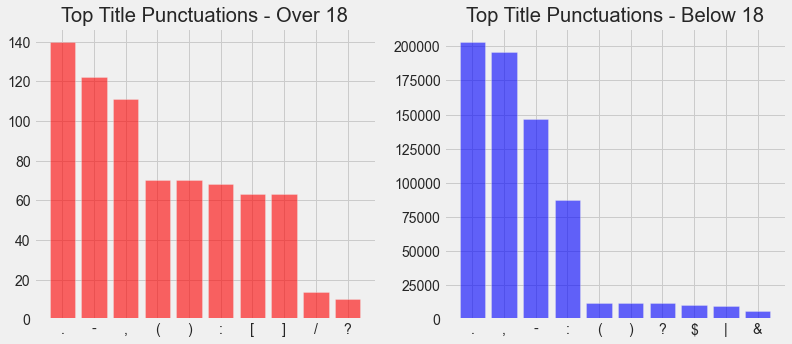

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

punc_o18_top10 = sorted(punc_o18.items(), key=lambda x: x[1], reverse=True)[:10]
punc, punc_cnt = zip(*punc_o18_top10)
axes[0].bar(punc, punc_cnt, color="red", alpha=0.6)
axes[0].set_title("Top Title Punctuations - Over 18")

punc_b18_top10 = sorted(punc_b18.items(), key=lambda x: x[1], reverse=True)[:10]
punc, punc_cnt = zip(*punc_b18_top10)
axes[1].bar(punc, punc_cnt, color="blue", alpha=0.6)
axes[1].set_title("Top Title Punctuations - Below 18")

plt.show()

### Stop words

In [27]:
def count_stopwords(titles):
    sw_count = defaultdict(int)
    
    stopwords_cached = stopwords.words("english")
    for title in titles:
        for word in title:
            if word in stopwords_cached:
                    sw_count[word] += 1
    return sw_count

In [28]:
stopwords_o18 = count_stopwords(get_corpus(over_18=True))
stopwords_o18_top10 = sorted(stopwords_o18.items(), key=lambda x: x[1], reverse=True)[:10]

stopwords_b18 = count_stopwords(get_corpus(over_18=False))
stopwords_b18_top10 = sorted(stopwords_b18.items(), key=lambda x: x[1], reverse=True)[:10]

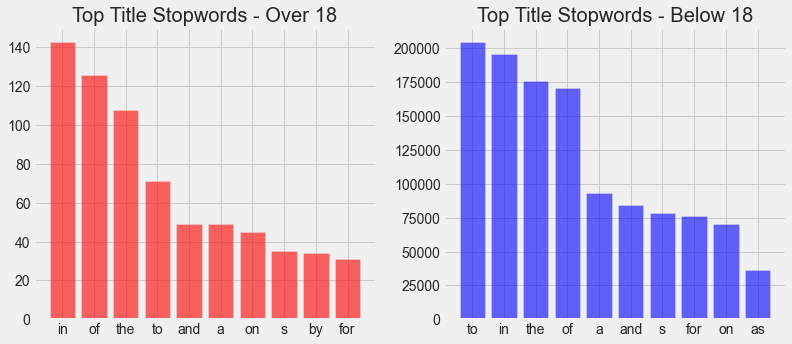

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

stopword, stopword_cnt = zip(*stopwords_o18_top10)
axes[0].bar(stopword, stopword_cnt, color="red", alpha=0.6)
axes[0].set_title("Top Title Stopwords - Over 18")

stopword, stopword_cnt = zip(*stopwords_b18_top10)
axes[1].bar(stopword, stopword_cnt, color="blue", alpha=0.6)
axes[1].set_title("Top Title Stopwords - Below 18")

plt.show()

### Length of title

In [30]:
dataset["title_length"] = dataset["title"].str.len()

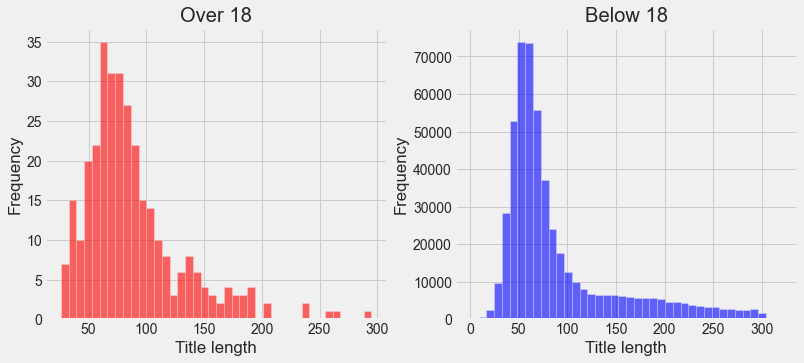

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax0 = dataset[dataset["over_18"]==True]["title_length"].plot(kind="hist", bins=40, color="red", title="Over 18", alpha=0.6, ax=axes[0])
ax0.set_xlabel("Title length")
ax1 = dataset[dataset["over_18"]==False]["title_length"].plot(kind="hist", bins=40, color="blue", title="Below 18", alpha=0.6, ax=axes[1])
ax1.set_xlabel("Title length")

plt.show()

### Number of words in title

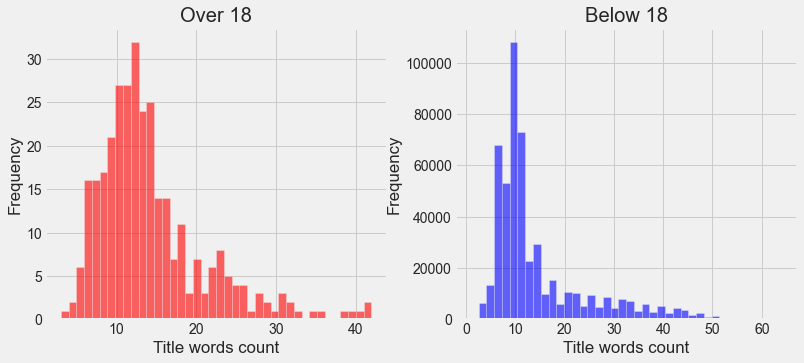

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax0 = get_corpus(over_18=True).apply(lambda x: len(x)).plot(kind="hist", bins=40, color="red", title="Over 18", alpha=0.6, ax=axes[0])
ax0.set_xlabel("Title words count")
ax1 = get_corpus(over_18=False).apply(lambda x: len(x)).plot(kind="hist", bins=40, color="blue", title="Below 18", alpha=0.6, ax=axes[1])
ax1.set_xlabel("Title words count")

plt.show()

### Average length of words

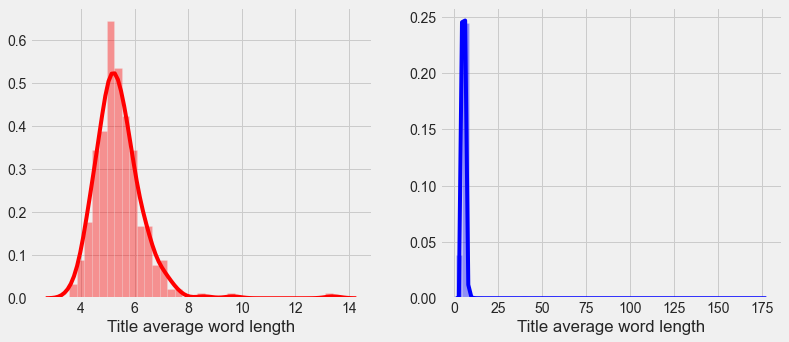

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

data_o18 = get_corpus(over_18=True).apply(lambda x: np.mean([len(word) for word in x]))
g = sns.distplot(data_o18, color="red", ax=axes[0])
g.set_xlabel("Title average word length")
data_b18 = get_corpus(over_18=False).apply(lambda x: np.mean([len(word) for word in x]))
g = sns.distplot(data_b18, color="blue", ax=axes[1])
# g.set_xticks(np.arange(0, 20, 1))
g.set_xlabel("Title average word length")

plt.show()

## 2) Preprocessing Title Column

### 2a) Remove URL

In [34]:
def remove_url(text):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
#     if re.search(url_pattern, text):
#         print(text)
    return re.sub(url_pattern, r"", text)

In [35]:
title1 = "World Notes: WHO investigation in Ukraine reports no significant change in H1N1 virus; Fragile health care syst.. http://bit.ly/1hBPqJ"
title2 = "Turkey blocked most http://*.google.com sites"
title3 = "http://www.comcast.net/data/fan/html/popup.html?v=1030143489&pl=Comcast/1030032788.xml&launchpoint=Cover&cid=fancover&attr=default_headline&config=/config/common/fan/default.xml"
title4 = "Sculpture by Eduardo Volks Soares.See more in http://eduardosoaresarts.wordpress.com/ or http://duvolks.deviantart.com/ .Enjoy,thanks!!"

print(remove_url(title1), remove_url(title2), remove_url(title3), remove_url(title4), sep="\n")

World Notes: WHO investigation in Ukraine reports no significant change in H1N1 virus; Fragile health care syst.. 
Turkey blocked most  sites

Sculpture by Eduardo Volks Soares.See more in  or  .Enjoy,thanks!!


In [36]:
dataset["title_nourl"] = dataset["title"].apply(lambda x: remove_url(x))

### 2b) Remove HTML tags (did not run)

In [37]:
def remove_html(text):
    html_pattern = re.compile(r"<.*?>")
    return re.sub(html_pattern, r"", text)

# Did not remove HTML tags, some useful keywords were in <.*?>

In [38]:
title1 = "<i>Milk</i> Cracks Top Ten (at only 36 Theaters!)"
title2 = "National Geographic Wildlife Filmmaker: <TEXTFORMAT LEADING= 3 ><P ALIGN= LEFT ><FONT FACE= Verdana  SIZE= 12  COLOR= #000000  LETTERSPACING= 0  KERNING= 0 >The Aswome Film Maded: By: Courtney Isley</FONT></P></TEXTFORMAT>"
title3 = "<NSFW> My uncle was killed today after praying Friday prayer in Libya"
title4 = "<BREAKING> Iran rivals claim poll victory "

print(remove_html(title1), remove_html(title2), remove_html(title3), remove_html(title4), sep="\n")

Milk Cracks Top Ten (at only 36 Theaters!)
National Geographic Wildlife Filmmaker: The Aswome Film Maded: By: Courtney Isley
 My uncle was killed today after praying Friday prayer in Libya
 Iran rivals claim poll victory 


### 2c) Remove Emojis

In [39]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return re.sub(emoji_pattern, r"", text)

In [40]:
title1 = "China To Pope Francis: Don t â��Interfere  With Our Country s Religion"
title2 = "Ant贸nio Guterres to be next UN secretary general | World news"
title3 = "Online fraudsters  steal �3.3bn"
title4 = "Taiwan - Dengue fever cases are surging in Southern Taiwan as the number of people infected reached a record high of 4,667, according to the Centers for Disease Control (CDC, 疾管局) \
         Beijing to see clearer skies as wind power breezes in｜WCT"

print(remove_emoji(title1), remove_emoji(title2), remove_emoji(title3), remove_emoji(title4), sep="\n")

China To Pope Francis: Don t âInterfere  With Our Country s Religion
Antnio Guterres to be next UN secretary general | World news
Online fraudsters  steal 3.3bn
Taiwan - Dengue fever cases are surging in Southern Taiwan as the number of people infected reached a record high of 4,667, according to the Centers for Disease Control (CDC, )          Beijing to see clearer skies as wind power breezes inWCT


In [41]:
dataset["title_noemoji"] = dataset["title_nourl"].apply(lambda x: remove_emoji(x))

### 2d) Add space around punctuations prior to removing punctuations and tokenization

In [42]:
def update_punctuation_spacing(text):
    words = text.split()
    updated_text = list()
    for word in words:
        has_punc = set(word[1:-1]).intersection(set(string.punctuation))
        if has_punc:
            punc_loc = word.index(list(has_punc)[0])
            word = word[:punc_loc] + " " + word[punc_loc] + " " + word[punc_loc+1:]
        updated_text.append(word)
    return " ".join(updated_text)

In [43]:
title1 = "Council of Europe bashes EU&UN terror blacklist"
title2 = "Jump-start economy: Give health care to all"
title3 = "US/NATO military shipping heroin out of Afghanistan"

print(update_punctuation_spacing(title1), update_punctuation_spacing(title2), update_punctuation_spacing(title3), sep="\n")

Council of Europe bashes EU & UN terror blacklist
Jump - start economy: Give health care to all
US / NATO military shipping heroin out of Afghanistan


In [44]:
dataset["title_spacing"] = dataset["title_noemoji"].apply(update_punctuation_spacing)
dataset["title_spacing"]

0                                                               Scores killed in Pakistan clashes
1                                                                Japan resumes refuelling mission
2                                                                 US presses Egypt on Gaza border
3                                                   Jump - start economy: Give health care to all
4                                               Council of Europe bashes EU & UN terror blacklist
                                                   ...                                           
509231    Heil Trump : Donald Trump s alt - right white nationalist supporters invoke Nazi salute
509232                      There are people speculating that this could be Madeleine McCann . ..
509233                                                  Professor receives Arab Researchers Award
509234                                    Nigel Farage attacks response to Trump ambassador tweet
509235              

### 2e) Remove Punctuations

In [45]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [46]:
# str.maketrans(x[, y[, z]])
# - If only one argument, it must be dictionary mapping Unicode ordinals(integers) or characters(strings of length 1) to Unicode ordinals, strings (of arbitrary lengths) or None. 
# - Character keys will then be converted to ordinals.
# - If two arguments, they must be strings of equal length, and in resulting dictionary, each character in x will be mapped to the character at the same position in y. 
# - If there is third argument, it must be a string, whose characters will be mapped to None in the result.

# slower
def remove_punctuation_2(text):
    no_punc = "".join([c for c in text if c not in string.punctuation])
    return no_punc

# fastest
def remove_punctuation(text):
    transtable = str.maketrans("", "", string.punctuation)
    return text.translate(transtable)

In [47]:
text = "hey there! what's going on today? where are you..%"

%timeit remove_punctuation(text * 10000)
%timeit remove_punctuation_2(text * 10000)

1.73 ms ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
85.5 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
print(remove_punctuation(text), remove_punctuation_2(text), sep="\n")

hey there whats going on today where are you
hey there whats going on today where are you


In [49]:
dataset["title_nopunc"] = dataset["title_spacing"].apply(lambda x: remove_punctuation(x))

dataset[["title", "title_nopunc"]][:5]

,title,title_nopunc
0,Scores killed in Pakistan clashes,Scores killed in Pakistan clashes
1,Japan resumes refuelling mission,Japan resumes refuelling mission
2,US presses Egypt on Gaza border,US presses Egypt on Gaza border
3,Jump-start economy: Give health care to all,Jump start economy Give health care to all
4,Council of Europe bashes EU&UN terror blacklist,Council of Europe bashes EU UN terror blacklist


### 2f) Correct spelling (did not run)

In [50]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spelling(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [51]:
text1 = "Plese give the shop a cal."
text2 = "corect me plese"

print(correct_spelling(text1), correct_spelling(text2), sep="\n")

Plese give the shop a call
correct me please


### 2g) Tokenization

In [52]:
# alphanumeric with 3 or more characters
# tokenizer = RegexpTokenizer(r"\w{3,}") 

# words with 3 or more characters
tokenizer = RegexpTokenizer(r"[a-zA-Z]{3,}")

In [53]:
dataset["title_token"] = dataset["title_nopunc"].apply(lambda x: tokenizer.tokenize(x.lower()))
dataset["title_token"]

0                                                                    [scores, killed, pakistan, clashes]
1                                                                  [japan, resumes, refuelling, mission]
2                                                                         [presses, egypt, gaza, border]
3                                                        [jump, start, economy, give, health, care, all]
4                                                           [council, europe, bashes, terror, blacklist]
                                                       ...                                              
509231    [heil, trump, donald, trump, alt, right, white, nationalist, supporters, invoke, nazi, salute]
509232                           [there, are, people, speculating, that, this, could, madeleine, mccann]
509233                                                   [professor, receives, arab, researchers, award]
509234                                      [nigel, far

### 2h) Remove Stop Words

In [54]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [55]:
# slowest
def remove_stopwords_3(text):
    no_stopwords = [w for w in text if w not in stopwords.words("english")]
    return no_stopwords

# fast
stopwords_cached = stopwords.words("english")
def remove_stopwords_2(text, stopwords_cached):
    no_stopwords = [w for w in text if w not in stopwords_cached]
    return no_stopwords

# fastest
stopwords_dict = Counter(stopwords.words("english"))
def remove_stopwords(text, stopwords_dict):
    no_stopwords = [w for w in text if w not in stopwords_dict]
    return no_stopwords

In [56]:
t0 = time.time()

dataset["title_token"] = dataset["title_token"].apply(lambda x: remove_stopwords(x, stopwords_dict))

print(f"Time taken: {round(time.time()-t0, 3)}")

Time taken: 3.232


In [57]:
dataset["title_token"]

0                                                                    [scores, killed, pakistan, clashes]
1                                                                  [japan, resumes, refuelling, mission]
2                                                                         [presses, egypt, gaza, border]
3                                                             [jump, start, economy, give, health, care]
4                                                           [council, europe, bashes, terror, blacklist]
                                                       ...                                              
509231    [heil, trump, donald, trump, alt, right, white, nationalist, supporters, invoke, nazi, salute]
509232                                                   [people, speculating, could, madeleine, mccann]
509233                                                   [professor, receives, arab, researchers, award]
509234                                      [nigel, far

### 2i) Stemming

In [58]:
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = [stemmer.stem(word) for word in text]
    return stem_text

In [59]:
dataset["title_stem"] = dataset["title_token"].apply(lambda x: word_stemmer(x))
dataset["title_stem"]

0                                                                    [score, kill, pakistan, clash]
1                                                                   [japan, resum, refuel, mission]
2                                                                      [press, egypt, gaza, border]
3                                                        [jump, start, economi, give, health, care]
4                                                         [council, europ, bash, terror, blacklist]
                                                    ...                                            
509231    [heil, trump, donald, trump, alt, right, white, nationalist, support, invok, nazi, salut]
509232                                                     [peopl, specul, could, madelein, mccann]
509233                                                   [professor, receiv, arab, research, award]
509234                                    [nigel, farag, attack, respons, trump, ambassador, tweet]


### 2j) Lemmatization

In [60]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lemma_text = [lemmatizer.lemmatize(word) for word in text]
    return lemma_text

In [61]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /Users/asd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
dataset["title_lemma"] = dataset["title_token"].apply(lambda x: word_lemmatizer(x))
dataset["title_lemma"]

0                                                                      [score, killed, pakistan, clash]
1                                                                  [japan, resume, refuelling, mission]
2                                                                          [press, egypt, gaza, border]
3                                                            [jump, start, economy, give, health, care]
4                                                            [council, europe, bash, terror, blacklist]
                                                      ...                                              
509231    [heil, trump, donald, trump, alt, right, white, nationalist, supporter, invoke, nazi, salute]
509232                                                  [people, speculating, could, madeleine, mccann]
509233                                                   [professor, receives, arab, researcher, award]
509234                                      [nigel, farage, atta

### 2k) WordCloud 

In [63]:
dataset_o18 = dataset[dataset["over_18"]==True]
dataset_b18 = dataset[dataset["over_18"]==False]

In [64]:
dataset_o18["title_lemma"]

1885                                                                                                     [pic, tibetan, protest, graphic, wikileaks, nsfw, graphic]
6721      [linked, max, mosley, nazi, style, sadomasochistic, sex, orgy, mosley, father, led, british, union, fascist, mother, great, admirer, adolf, hitler, nsfw]
8414                                                   [tabloid, horrifies, germany, poland, yellow, press, turn, blood, red, follow, link, gallery, picture, nsfw]
12163                                                                           [love, parade, dortmund, techno, festival, break, record, million, nsfw, thumbnail]
12699                                                                                                       [idf, kill, young, palestinian, boy, potentially, nsfw]
                                                                                    ...                                                                            
503776          

In [65]:
dataset_b18["title_lemma"]

0                                                                      [score, killed, pakistan, clash]
1                                                                  [japan, resume, refuelling, mission]
2                                                                          [press, egypt, gaza, border]
3                                                            [jump, start, economy, give, health, care]
4                                                            [council, europe, bash, terror, blacklist]
                                                      ...                                              
509231    [heil, trump, donald, trump, alt, right, white, nationalist, supporter, invoke, nazi, salute]
509232                                                  [people, speculating, could, madeleine, mccann]
509233                                                   [professor, receives, arab, researcher, award]
509234                                      [nigel, farage, atta

In [66]:
words_o18 = " ".join(chain.from_iterable(dataset_o18["title_lemma"].values))
words_b18 = " ".join(chain.from_iterable(dataset_b18["title_lemma"].values))

In [67]:
print(len(words_o18), len(words_b18), sep="\n")
print(words_o18[:50], words_b18[:50], sep="\n")

21845
35430541
pic tibetan protest graphic wikileaks nsfw graphic
score killed pakistan clash japan resume refuellin


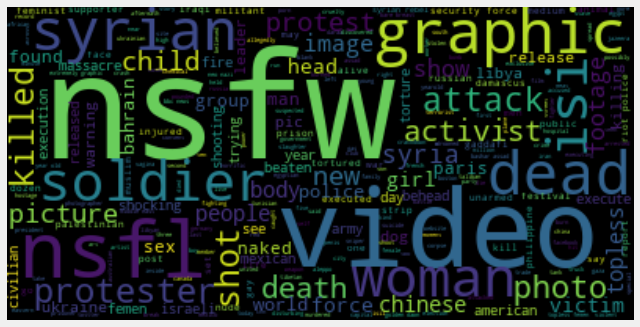

In [68]:
import PIL
from wordcloud import WordCloud

wordcloud = WordCloud(max_words=1000, margin=0).generate(words_o18)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

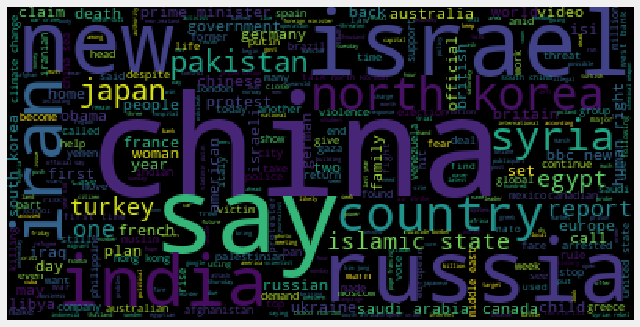

In [69]:
wordcloud = WordCloud(max_words=1000, margin=0).generate(words_b18)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="nearest")
plt.axis("off")
plt.show()

### 2l) Imbalanced Dataset: Undersampling of majority class to generate training and test set

In [70]:
# join stemmed tokens back into sentence
# dataset["title_stemmed"] = dataset["title_stem"].apply(lambda x: " ".join(x))

# join lemmatized tokens back into sentence
dataset["title_lemmatized"] = dataset["title_lemma"].apply(lambda x: " ".join(x))

In [71]:
X = dataset["title_lemmatized"].values
y = dataset["restricted_content"].values

print(X.shape, y.shape)

(509236,) (509236,)


In [72]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(X.reshape(-1, 1), y.reshape(-1, 1))

Using TensorFlow backend.


In [73]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
# for train_idx, test_idx in sss.split(X, y):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(512, 1) (128, 1) (512,) (128,)


In [74]:
pd.value_counts(y_train, normalize=True), pd.value_counts(y_test, normalize=True)

(1    0.519531
 0    0.480469
 dtype: float64,
 0    0.578125
 1    0.421875
 dtype: float64)

## 3) Feature Generation
### 3a) Bag of Words (BoW) - Manual Counting

In [75]:
from operator import itemgetter, attrgetter

def get_bag_of_words(text):
    bag_of_words = defaultdict(int)
    for sentence in text:
        for word in sentence:
            bag_of_words[word] += 1
    return bag_of_words

In [76]:
bow_o18 = get_bag_of_words(dataset_o18["title_lemma"].values)
print(type(bow_o18), type(bow_o18.items()))

sorted(bow_o18.items(), key=itemgetter(1), reverse=True)[:10]

<class 'collections.defaultdict'> <class 'dict_items'>


[('nsfw', 126),
 ('video', 58),
 ('graphic', 27),
 ('nsfl', 26),
 ('syrian', 26),
 ('dead', 22),
 ('isi', 20),
 ('woman', 19),
 ('soldier', 19),
 ('protester', 19)]

In [77]:
bow_b18 = get_bag_of_words(dataset_b18["title_lemma"].values)

sorted(bow_b18.items(), key=itemgetter(1), reverse=True)[:10]

[('say', 32909),
 ('china', 26377),
 ('new', 23376),
 ('attack', 19801),
 ('syria', 19005),
 ('russia', 18756),
 ('year', 18214),
 ('world', 18185),
 ('state', 17084),
 ('government', 17005)]

### 3b) Bag of Words (BoW) - CountVectorizer

In [78]:
X_train = pd.Series(X_train.reshape(-1))
X_test = pd.Series(X_test.reshape(-1))

In [79]:
cvec = CountVectorizer(stop_words=stopwords.words("english"), ngram_range=(1, 1), max_df=0.5, token_pattern=r"[a-zA-Z]{3,}")
cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.5, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='[a-zA-Z]{3,}',
                tokenizer=None, vocabulary=None)

In [80]:
cvec.get_feature_names()[:10]

['abandoned',
 'abbott',
 'abbottabad',
 'abdeslam',
 'ablaze',
 'able',
 'abortion',
 'abroad',
 'abu',
 'abuse']

In [81]:
# End of dictionary 

sorted(cvec.vocabulary_.items(), key= lambda x: x[1], reverse=True)[:10]

[('zika', 2372),
 ('zeta', 2371),
 ('zealand', 2370),
 ('zawiyah', 2369),
 ('zacatecas', 2368),
 ('youth', 2367),
 ('young', 2366),
 ('yorkshire', 2365),
 ('york', 2364),
 ('yezidi', 2363)]

In [82]:
# Start of dictionary

sorted(cvec.vocabulary_.items(), key= lambda x: x[1], reverse=False)[:10]

[('abandoned', 0),
 ('abbott', 1),
 ('abbottabad', 2),
 ('abdeslam', 3),
 ('ablaze', 4),
 ('able', 5),
 ('abortion', 6),
 ('abroad', 7),
 ('abu', 8),
 ('abuse', 9)]

In [83]:
X_train_dtm = cvec.transform(X_train)
X_test_dtm = cvec.transform(X_test)

X_train_dtm, X_test_dtm

(<512x2373 sparse matrix of type '<class 'numpy.int64'>'
 	with 4807 stored elements in Compressed Sparse Row format>,
 <128x2373 sparse matrix of type '<class 'numpy.int64'>'
 	with 806 stored elements in Compressed Sparse Row format>)

In [84]:
# Model Prediction - Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

y_pred = mnb.predict(X_test_dtm)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}", f"Precision: {precision_score(y_test, y_pred):.4f}", f"Recall: {recall_score(y_test, y_pred):.4f}", sep="\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7656
Precision: 0.6714
Recall: 0.8704
[[51 23]
 [ 7 47]]


In [86]:
y_pred_proba = mnb.predict_proba(X_test_dtm)[:, 1]
y_pred_proba.shape

(128,)

In [87]:
roc_auc_score(y_test, y_pred_proba)

0.8706206206206206

In [88]:
# Model Prediction - Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="liblinear")
lr.fit(X_train_dtm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
y_pred = lr.predict(X_test_dtm)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}", f"Precision: {precision_score(y_test, y_pred):.4f}", f"Recall: {recall_score(y_test, y_pred):.4f}", sep="\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8359
Precision: 0.9024
Recall: 0.6852
[[70  4]
 [17 37]]


In [90]:
y_pred_proba = lr.predict_proba(X_test_dtm)[:, 1]
y_pred_proba.shape

(128,)

In [91]:
roc_auc_score(y_test, y_pred_proba)

0.9084084084084083

### Term Frequency - Inverse Document Frequency (Tf-idf) 
##### TF(t) = (# times term t appears in a document) / (Total # of terms in the document).
##### IDF(t) = log_e(Total # of documents / # of documents with term t in it).
##### tf-idf weight is product of two terms

### 3c) TfidfTransformer: Transform BoW document-term matrix to a normalized tf or tf-idf representation

In [92]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_tf = TfidfTransformer()
tfidf_tf.fit(X_train_dtm)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [93]:
X_train_tfidf = tfidf_tf.transform(X_train_dtm)
X_test_tfidf = tfidf_tf.transform(X_test_dtm)

X_train_tfidf, X_test_tfidf

(<512x2373 sparse matrix of type '<class 'numpy.float64'>'
 	with 4807 stored elements in Compressed Sparse Row format>,
 <128x2373 sparse matrix of type '<class 'numpy.float64'>'
 	with 806 stored elements in Compressed Sparse Row format>)

In [94]:
# Model Prediction - Multinomial Naive Bayes

mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [95]:
y_pred = mnb.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}", f"Precision: {precision_score(y_test, y_pred):.4f}", f"Recall: {recall_score(y_test, y_pred):.4f}", sep="\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7422
Precision: 0.6364
Recall: 0.9074
[[46 28]
 [ 5 49]]


In [96]:
y_pred_proba = mnb.predict_proba(X_test_tfidf)[:, 1]

In [97]:
roc_auc_score(y_test, y_pred_proba)

0.8543543543543544

In [98]:
# Model Prediction - Logistic Regression

lr = LogisticRegression(solver="liblinear")
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
y_pred = lr.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}", f"Precision: {precision_score(y_test, y_pred):.4f}", f"Recall: {recall_score(y_test, y_pred):.4f}", sep="\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8125
Precision: 0.7679
Recall: 0.7963
[[61 13]
 [11 43]]


In [100]:
y_pred_proba = lr.predict_proba(X_test_tfidf)[:, 1]

In [101]:
roc_auc_score(y_test, y_pred_proba)

0.8943943943943944

### 3d) TfidfVectorizer (alternative to CountVectorizer + TfidfTransformer)

In [102]:
# Experimenting with max_features=2000, ngram_range=(1, 2) and min_df=2

tfidf_vec = TfidfVectorizer(stop_words=stopwords.words("english"), max_features=2000, min_df=2, max_df=0.5, ngram_range=(1,2), token_pattern=r"[a-zA-Z]{3,}")
tfidf_vec.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=2000,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='[a-zA-Z]{3,}', tokenizer=None, use_idf=True,
                vocabulary=None)

In [103]:
dictionary = tfidf_vec.vocabulary_.items()
len(dictionary)

895

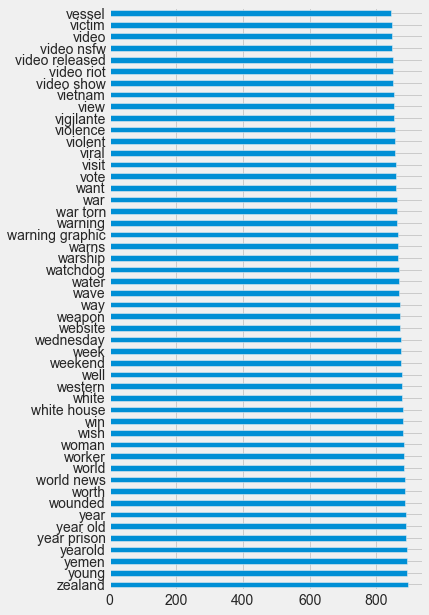

In [104]:
vocab = list()
count = list()

for key, value in dictionary:
    vocab.append(key)
    count.append(value)

vocab_after_stem = pd.Series(count, index=vocab)
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)

top_vocab = vocab_after_stem.head(50)
top_vocab.plot(kind="barh", figsize=(5, 10))

In [105]:
X_train_tfidf_vec = tfidf_vec.transform(X_train)
X_test_tfidf_vec = tfidf_vec.transform(X_test)

X_train_tfidf_vec, X_test_tfidf_vec

(<512x895 sparse matrix of type '<class 'numpy.float64'>'
 	with 3522 stored elements in Compressed Sparse Row format>,
 <128x895 sparse matrix of type '<class 'numpy.float64'>'
 	with 634 stored elements in Compressed Sparse Row format>)

In [106]:
# Model Prediction - Multinomial Naive Bayes

mnb = MultinomialNB()
mnb.fit(X_train_tfidf_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [107]:
y_pred = mnb.predict(X_test_tfidf_vec)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}", f"Precision: {precision_score(y_test, y_pred):.4f}", f"Recall: {recall_score(y_test, y_pred):.4f}", sep="\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7344
Precision: 0.6515
Recall: 0.7963
[[51 23]
 [11 43]]


In [108]:
y_pred_proba = mnb.predict_proba(X_test_tfidf_vec)[:, 1]

In [109]:
roc_auc_score(y_test, y_pred_proba)

0.8636136136136137

In [110]:
# Model Prediction - Logistic Regression

lr = LogisticRegression(solver="liblinear")
lr.fit(X_train_tfidf_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
y_pred = lr.predict(X_test_tfidf_vec)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}", f"Precision: {precision_score(y_test, y_pred):.4f}", f"Recall: {recall_score(y_test, y_pred):.4f}", sep="\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8281
Precision: 0.8077
Recall: 0.7778
[[64 10]
 [12 42]]


In [112]:
y_pred_proba = lr.predict_proba(X_test_tfidf_vec)[:, 1]

In [113]:
roc_auc_score(y_test, y_pred_proba)

0.8976476476476477

### Analyze titles which were false positives

In [114]:
X_test[y_pred > y_test]

5                                                                                                                              abramovich accuses rival tycoon link chechen terrorist
21                                                                                                                               turkish medium criticised muted response protest com
26     reuters gunman nigeria boko haram islamist group attacked northeastern town bama wednesday opening fire school shooting burning death people trashing palace traditional ruler
33                                                                                                                                             chile nabs dutchman peru killing video
34                                                                                                 oslo terrorist attack change anything norwegian police maintain stance bearing arm
41                                                                                        

### Analyze titles which were false negatives

In [115]:
X_test[y_pred < y_test]

13                                                                                             store owner hang poor dog death relocation dispute
31                                                                                       chinese fisher face charge poached turtle philippine sea
36                                                                                             latest italian earthquake devastates medieval site
39                                                                       secret halal slaughterhouse film reveals horrific animal abuse telegraph
43                                                                                        drowned baby picture capture week tragedy mediterranean
48                                                   abominable failure former leader troubled security agency say may suffering complacency gene
63                                                                                                bbc news phone hacking bro

## 4) Word2Vec (Word Embedding)
### 4a) Continuous Bag of Words (CBOW)
##### Surrounding words of a selected word are used as inputs, selected word as target

In [116]:
model = Word2Vec(dataset["title_lemma"], min_count=1, window=2, size=300)

In [117]:
model.wv.vocab

{'score': <gensim.models.keyedvectors.Vocab at 0x196d89510>,
 'killed': <gensim.models.keyedvectors.Vocab at 0x196d8b110>,
 'pakistan': <gensim.models.keyedvectors.Vocab at 0x196d8b550>,
 'clash': <gensim.models.keyedvectors.Vocab at 0x196d8b610>,
 'japan': <gensim.models.keyedvectors.Vocab at 0x196d8b390>,
 'resume': <gensim.models.keyedvectors.Vocab at 0x196d8b4d0>,
 'refuelling': <gensim.models.keyedvectors.Vocab at 0x196d8bb90>,
 'mission': <gensim.models.keyedvectors.Vocab at 0x196d8bf10>,
 'press': <gensim.models.keyedvectors.Vocab at 0x196d8b1d0>,
 'egypt': <gensim.models.keyedvectors.Vocab at 0x196d8b490>,
 'gaza': <gensim.models.keyedvectors.Vocab at 0x196d8b710>,
 'border': <gensim.models.keyedvectors.Vocab at 0x196d8bf50>,
 'jump': <gensim.models.keyedvectors.Vocab at 0x196d8bf90>,
 'start': <gensim.models.keyedvectors.Vocab at 0x196d8bfd0>,
 'economy': <gensim.models.keyedvectors.Vocab at 0x196eab050>,
 'give': <gensim.models.keyedvectors.Vocab at 0x196eab090>,
 'health': <

In [118]:
model.wv.similarity("nsfw", "nsfl"), model.wv.similarity("nsfw", "starbucks")

(0.8053264, 0.19087793)

In [119]:
model.wv.most_similar(positive=["italy", "berlin"], negative=["rome"])

[('greece', 0.6643576622009277),
 ('germany', 0.6637238264083862),
 ('austria', 0.6623954772949219),
 ('cyprus', 0.6058561205863953),
 ('britain', 0.5873163938522339),
 ('hungary', 0.5869173407554626),
 ('poland', 0.5684281587600708),
 ('greek', 0.5644333362579346),
 ('german', 0.557472288608551),
 ('europe', 0.5559564828872681)]

In [120]:
model.wv.similar_by_word("nsfw", topn=10)

[('sickening', 0.8298652172088623),
 ('uploaded', 0.8122677206993103),
 ('nsfl', 0.8053264617919922),
 ('weeping', 0.7841018438339233),
 ('amateur', 0.7806322574615479),
 ('clip', 0.7792980670928955),
 ('graphic', 0.7758225202560425),
 ('surfaced', 0.7756587266921997),
 ('heartbreaking', 0.7753111124038696),
 ('cyberlocker', 0.7727288603782654)]

In [121]:
model.wv.similar_by_word("tax", topn=10)

[('mortgage', 0.6372409462928772),
 ('fee', 0.6349207758903503),
 ('bonus', 0.6182417273521423),
 ('pension', 0.6142501831054688),
 ('tuition', 0.6129200458526611),
 ('fine', 0.6063851118087769),
 ('evasion', 0.5951464176177979),
 ('hefty', 0.5916736125946045),
 ('libor', 0.5862178802490234),
 ('revenue', 0.5861579179763794)]

In [122]:
model.wv.doesnt_match(["nsfl", "graphic", "pricing"])

/Users/asd/.virtualenvs/ds/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'pricing'

### 4b) Skip-Gram
##### Selected word is used as input, surrounding words of a selected word as target
##### One-hot encoded input vector --> Hidden layer (linear neurons, no activation function, operating as lookup table) --> Output layer (softmax classifier)

In [123]:
# set sg=1 to enable skip-gram

model = Word2Vec(dataset["title_lemma"], min_count=1, window=2, size=300, sg=1)

In [124]:
model.wv.similar_by_word("nsfw", topn=10)

[('nsfl', 0.868948757648468),
 ('sickening', 0.8149281740188599),
 ('heartbreaking', 0.812401294708252),
 ('gopro', 0.8123703002929688),
 ('gory', 0.8083289861679077),
 ('purportedly', 0.804743766784668),
 ('caption', 0.8043756484985352),
 ('uploaded', 0.7963505983352661),
 ('unbelievable', 0.7950990796089172),
 ('distressing', 0.7930578589439392)]

In [125]:
model.wv.similar_by_word("tax", topn=10)

[('evasion', 0.6026483774185181),
 ('dodger', 0.5799539685249329),
 ('avoidance', 0.5748193264007568),
 ('taxation', 0.560482919216156),
 ('levy', 0.5570968389511108),
 ('recoup', 0.5563083291053772),
 ('vat', 0.5524723529815674),
 ('pricing', 0.5500563383102417),
 ('evaders', 0.5498430132865906),
 ('multinationals', 0.5486768484115601)]

## 5) Topic Modeling
### 5a) Latent Semantic Analysis (LSA)
##### This is effectively a truncated singular value decomposition of a very high-rank and sparse document-term matrix, with only the r=n_topics largest singular values preserved.

In [126]:
from sklearn.decomposition import TruncatedSVD

n_topics = 5

lsa = TruncatedSVD(n_components=n_topics, n_iter=10)
lsa

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=10,
             random_state=None, tol=0.0)

In [127]:
lsa_topic_matrix = lsa.fit_transform(X_train_tfidf_vec)

In [128]:
lsa_topic_matrix.shape, lsa_topic_matrix

((512, 5),
 array([[ 0.036, -0.012,  0.067,  0.045, -0.029],
        [ 0.078, -0.179,  0.242,  0.203, -0.111],
        [ 0.024,  0.001,  0.003, -0.013, -0.011],
        ...,
        [ 0.004, -0.003,  0.009,  0.002, -0.004],
        [ 0.041, -0.047,  0.096, -0.02 , -0.04 ],
        [ 0.144,  0.082,  0.048,  0.001, -0.023]]))

In [129]:
# classify documents into topics 

lsa_keys = lsa_topic_matrix.argmax(axis=1)
lsa_keys.shape

(512,)

In [130]:
def keys_to_counts(lsa_keys):
    cat_cnt = defaultdict(list)
    count_pairs = Counter(lsa_keys).items()
    
    for category, count in count_pairs:
        cat_cnt["category"].append(category)
        cat_cnt["count"].append(count)
    return cat_cnt["category"], cat_cnt["count"]

In [131]:
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
lsa_categories, lsa_counts

([2, 0, 3, 4, 1], [142, 319, 29, 21, 1])

In [132]:
lsa_dictionary = tfidf_vec.get_feature_names()
len(lsa_dictionary)

895

In [133]:
lsa.components_.shape

(5, 895)

In [134]:
def get_top_n_words(model, dictionary, n_words):
    for idx, comp in enumerate(model.components_):
        dict_comp = zip(dictionary, comp)
        sorted_terms = sorted(dict_comp, key=lambda x: x[1], reverse=True)[:n_words]
        print(f"Topic {idx+1}: ", " ".join(term for term, prob in sorted_terms))

In [135]:
get_top_n_words(lsa, lsa_dictionary, 10)

Topic 1:  nsfw video graphic nsfl syrian dead shot protester soldier woman
Topic 2:  nsfw shot protest topless protester head iran police image activist
Topic 3:  korea north say north korea new year south woman nsfw sex
Topic 4:  news bbc bbc news picture photo say russian world gaddafi rule
Topic 5:  new video europe graphic reach news korea isi north bbc


In [136]:
import umap

umap_vis = umap.UMAP(n_neighbors=100, min_dist=0.25)
umap_vis

/Users/asd/.virtualenvs/ds/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.25, n_components=2, n_epochs=None,
     n_neighbors=100, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [137]:
lsa_embedding = umap_vis.fit_transform(lsa_topic_matrix)

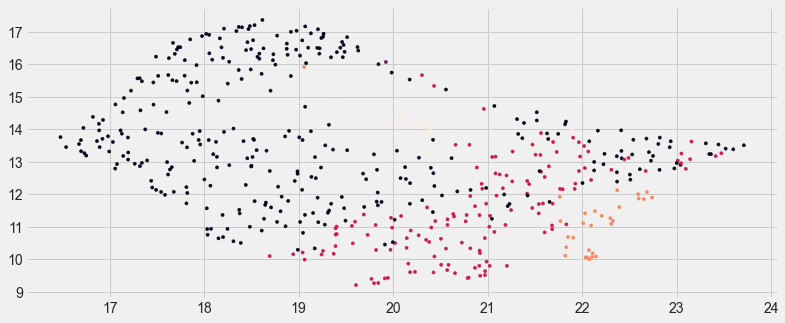

In [138]:
dataset_target = np.argmax(lsa_topic_matrix, axis=1)

plt.figure(figsize=(12, 5))
plt.scatter(lsa_embedding[:, 0], lsa_embedding[:, 1], s=10, c=dataset_target, edgecolors=None)
plt.show()

### 5b) Latent Dirichlet Allocation (LDA)

##### Probabilistic, generative model that uncovers the topics latent to dataset
##### Assigns weights to words in a corpus, where each topic will assign different probability weights to each word

In [139]:
from sklearn.decomposition import LatentDirichletAllocation

# n_components determined using K-Means Clustering and LSA, number of clusters and LSA dimensions chosen based on best silhouette score

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method="online", learning_offset=50)
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [140]:
lda.fit(X_train_tfidf_vec)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [141]:
lda_dictionary = tfidf_vec.get_feature_names()
len(lda_dictionary)

895

In [142]:
get_top_n_words(lda, lda_dictionary, 10)

Topic 1:  nsfw dead news year graphic child shot picture footage nsfl
Topic 2:  nsfw syrian force soldier activist video rebel man girl army
Topic 3:  video say killed syria isi war country release russia woman
Topic 4:  new korea china north world prime president american dog prime minister
Topic 5:  police video nsfw alive protester iran chinese dozen russian attack


In [143]:
lda_topic_matrix = lda.transform(X_train_tfidf_vec)

In [144]:
umap_vis = umap.UMAP(n_neighbors=100, min_dist=0.25)
umap_vis

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.25, n_components=2, n_epochs=None,
     n_neighbors=100, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [145]:
lda_embedding = umap_vis.fit_transform(lda_topic_matrix)

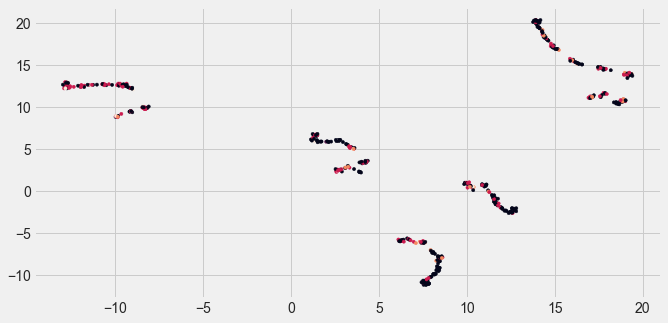

In [146]:
dataset_target = np.argmax(lsa_topic_matrix, axis=1)

plt.figure(figsize=(10, 5))
plt.scatter(lda_embedding[:, 0], lda_embedding[:, 1], s=10, c=dataset_target, edgecolors=None)
plt.show()